[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cca-cce/osm-cca/blob/main/jnb/simm71/nlp3_lecture.ipynb)


# Research question

**Introduction**

A **Naive Bayes classifier** can be trained to distinguish between **authentic sustainability communication** and **inauthentic greenwashing communication** by leveraging labeled text data from both organizations. Each sentence, labeled as either "sustainability" or "greenwashing," serves as a training example. The classifier learns the probability of words appearing in each category, assuming conditional independence of words (a simplifying assumption of the Naive Bayes algorithm). This enables the model to predict the likelihood of a new sentence belonging to one of these two categories based on its word composition.

**Comparing Sustainability and Greenwashing Across Organizations**

Using this approach, we can compare the levels of sustainability versus greenwashing communication in Preem and Vattenfall. Since Preem operates in the fossil fuel sector (inherently less sustainable), we might expect a higher proportion of sentences classified as "greenwashing." Conversely, Vattenfall, focusing on renewable energy, may exhibit a higher proportion of "sustainability" sentences. These results could provide quantitative insights into how each organization frames its sustainability narrative.

**Generalizing to Unseen Texts**

Moreover, the Naive Bayes model can generalize to **unseen texts** by applying the learned word probabilities to predict the classification of new sentences. This allows the model to analyze sustainability communication from other organizations. While the model's effectiveness depends on the representativeness of the training data, its simplicity and ability to handle sparse data make it a powerful tool for detecting patterns in sustainability messaging across diverse contexts. By refining the model with additional data and adjusting for domain-specific language, it could become a valuable asset in analyzing corporate communication practices.

# Download TSV text data

In [1]:
# https://drive.google.com/file/d/1fEfnTrEkBBJGAEvzGaY20Ls4eotz9iBz/view?usp=sharing
!rm -rf *.zip 2>/dev/null
!gdown https://drive.google.com/uc?id=1fEfnTrEkBBJGAEvzGaY20Ls4eotz9iBz
!unzip -q *.zip 2>/dev/null

Downloading...
From: https://drive.google.com/uc?id=1fEfnTrEkBBJGAEvzGaY20Ls4eotz9iBz
To: /content/df_sentences.tsv
100% 55.2k/55.2k [00:00<00:00, 66.6MB/s]


# Read TSV text data to Pandas Dataframe

In [2]:
import pandas as pd

# Read the TSV file into a DataFrame
df_texts = pd.read_csv('df_sentences.tsv', sep='\t')

# Display the first few rows of the DataFrame
df_texts.head()


,text_index,folder_name,sentence_index,sentence_text
0,1,org1-preem,1,Carbon Capture and Storage | Preem https://www...
1,1,org1-preem,2,Our commitment to carbon capture and storage P...
2,1,org1-preem,3,This is why we are working actively to enable ...
3,1,org1-preem,4,"Tests have been conducted with good results, a..."
4,1,org1-preem,5,"The ""Preem CCS"" pilot project has analyzed eve..."


In [3]:
df_texts.shape

(350, 4)

**N.B. max 10 rows for NLP assignment!** Sample or truncate if dataset contains more texts.

# Text normalization of sentence data

In [4]:
# for more languages, check https://spacy.io/models
!python -m spacy download en_core_web_md >/dev/null 2>&1


In [5]:
import pandas as pd
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_md")

# Function to clean text using SpaCy
def clean_text(text):
    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_.lower().strip() for token in doc
        if not token.is_stop  # Remove stopwords
        and not token.is_oov  # Exclude out-of-vocabulary (OOV) tokens
        and token.is_alpha    # Keep only alphabetic tokens
    ]
    # Join tokens back into a single string with normalized whitespace
    return " ".join(cleaned_tokens)

# Apply the cleaning function to the 'sentence_text' column
df_texts['cleaned_text'] = df_texts['sentence_text'].apply(clean_text)

# Display the DataFrame with the new column
df_texts.head()


,text_index,folder_name,sentence_index,sentence_text,cleaned_text
0,1,org1-preem,1,Carbon Capture and Storage | Preem https://www...,carbon capture storage preem home projects car...
1,1,org1-preem,2,Our commitment to carbon capture and storage P...,commitment carbon capture storage preem refine...
2,1,org1-preem,3,This is why we are working actively to enable ...,work actively enable capture storage carbon di...
3,1,org1-preem,4,"Tests have been conducted with good results, a...",test conduct good result plan establish scale ...
4,1,org1-preem,5,"The ""Preem CCS"" pilot project has analyzed eve...",preem ccs pilot project analyze capture store ...


**Load SpaCy Model**: The SpaCy model `en_core_web_md` is loaded to perform NLP tasks such as tokenization, lemmatization, and stopword removal. This step sets up the model for text preprocessing. Example: `nlp = spacy.load("en_core_web_md")`.

**Define Text Cleaning Function**: A `clean_text` function is defined to process text by tokenizing it, removing stopwords (`token.is_stop`), excluding out-of-vocabulary tokens (`token.is_oov`), keeping only alphabetic tokens (`token.is_alpha`), and lemmatizing tokens (`token.lemma_`) to lowercase. The cleaned tokens are joined into a single string with normalized whitespace. Example: `cleaned_tokens = [token.lemma_.lower() for token in doc if not token.is_stop]`.

**Apply Cleaning Function to Data**: The `clean_text` function is applied to the `sentence_text` column of the DataFrame (`df_texts`), and the cleaned text is stored in a new column called `cleaned_text`, enabling efficient text preprocessing for analysis. Example: `df_texts['cleaned_text'] = df_texts['sentence_text'].apply(clean_text)`.

**Display the Updated DataFrame**: The updated DataFrame, which includes the `cleaned_text` column, is displayed to verify the preprocessing results. Example: `df_texts.head()`.

# Split text data into train and test sets

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Split the dataset into training and testing sets (80% train, 20% test)
X = df_texts['cleaned_text']  # Features
y = df_texts['folder_name']   # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Import Libraries**: The necessary libraries are imported to handle data manipulation (`pandas`), split data into training and testing sets (`train_test_split`), perform feature extraction with `CountVectorizer`, train a Naive Bayes classifier (`MultinomialNB`), and evaluate the model using metrics such as accuracy and classification reports (`classification_report`, `accuracy_score`). Example: `from sklearn.model_selection import train_test_split`.

**Define Features and Labels**: The `cleaned_text` column is set as the feature (`X`), and the `folder_name` column is used as the label (`y`). These variables define the inputs and outputs for the classification model. Example: `X = df_texts['cleaned_text']` and `y = df_texts['folder_name']`.

**Split Dataset**: The dataset is split into training (80%) and testing (20%) sets using `train_test_split`. The `random_state=42` ensures reproducibility, making the split consistent across runs. Example: `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)`.

In [7]:
X_train.head()

,cleaned_text
228,follow vattenfall vattenfall european energy c...
78,preem want shift fossil gas fossil free hydrog...
90,convert plant reduce fossil carbon dioxide emi...
16,conduct carbon capture test lysekil refinery g...
66,reach goal time work interim goal reduce direc...


In [8]:
X_train.shape, X_test.shape

((280,), (70,))

# Train a Naive Bayes text classifier

In [9]:
# Convert text data to a document-term matrix using CountVectorizer
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)  # Fit on train, transform train
X_test_dtm = vectorizer.transform(X_test)       # Transform test

# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB()

**Convert Text to Document-Term Matrix**: The `CountVectorizer` is initialized to transform text data into a document-term matrix (DTM), where each row represents a document and each column represents a word with its corresponding frequency. The vectorizer is fit to the training data (`X_train`) and used to transform both the training and testing sets into numerical representations. Example: `X_train_dtm = vectorizer.fit_transform(X_train)` and `X_test_dtm = vectorizer.transform(X_test)`.

**Train Naive Bayes Classifier**: A `MultinomialNB` classifier is initialized and trained using the document-term matrix of the training data (`X_train_dtm`) and the corresponding labels (`y_train`). This step builds the classification model based on word frequencies in the training data. Example: `nb.fit(X_train_dtm, y_train)`.

# Predict binary text class with Naive Bayes

In [10]:
# Make predictions on the test set
y_pred = nb.predict(X_test_dtm)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9428571428571428

Classification Report:
                  precision    recall  f1-score   support

     org1-preem       0.94      0.94      0.94        32
org2-vattenfall       0.95      0.95      0.95        38

       accuracy                           0.94        70
      macro avg       0.94      0.94      0.94        70
   weighted avg       0.94      0.94      0.94        70



**Make Predictions**: The trained Naive Bayes model is used to predict the labels for the test set by applying it to the document-term matrix of the test data (`X_test_dtm`). This generates the predicted labels (`y_pred`) for evaluation. Example: `y_pred = nb.predict(X_test_dtm)`.

**Evaluate the Model**: The model’s performance is assessed by calculating the accuracy and generating a detailed classification report. The accuracy provides an overall measure of correctness, while the classification report includes precision, recall, and F1-score for each class. Example: `print("Accuracy:", accuracy_score(y_test, y_pred))` and `print(classification_report(y_test, y_pred))`.

# Evaluate results with confusion matrix

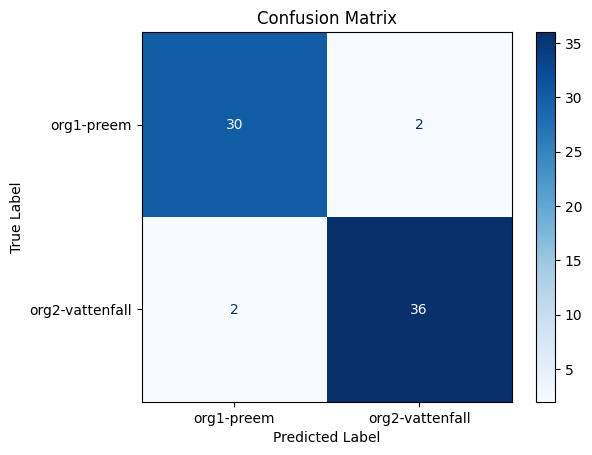

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**Generate Confusion Matrix**: The confusion matrix is calculated to compare the true labels (`y_test`) with the predicted labels (`y_pred`). This matrix shows the number of correct and incorrect predictions for each class, providing insights into classification performance. Example: `cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)`.

**Visualize Confusion Matrix**: The confusion matrix is visualized using `ConfusionMatrixDisplay`, which renders the matrix as a heatmap with labels for better interpretation. The `cmap='Blues'` sets the color scheme, and `values_format='d'` ensures integer values are displayed. Example: `disp.plot(cmap='Blues', values_format='d')`.

**Add Title and Labels**: Titles and axis labels are added to enhance readability. The matrix is displayed using `plt.show()`, making it easier to interpret the model's performance across different classes. Example: `plt.title("Confusion Matrix")` and `plt.xlabel("Predicted Label")`.

# Examine top predictive terms

In [12]:
import numpy as np

# Get the class labels from the classifier
class_labels = nb.classes_

# Get the feature names (terms) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of each feature given each class
class_probabilities = nb.feature_log_prob_

# Find the top 10 most predictive terms for each class
for i, class_label in enumerate(class_labels):
    top_indices = np.argsort(class_probabilities[i])[::-1][:10]  # Indices of top 10 terms
    top_terms = [feature_names[j] for j in top_indices]
    top_scores = class_probabilities[i][top_indices]
    print(f"Top 10 terms for class '{class_label}':")
    for term, score in zip(top_terms, top_scores):
        print(f"  {term}: {score:.4f}")
    print()


Top 10 terms for class 'org1-preem':
  preem: -3.8081
  carbon: -4.0157
  renewable: -4.1827
  emission: -4.3470
  project: -4.5012
  production: -4.5012
  capture: -4.5438
  fossil: -4.6347
  plant: -4.7348
  dioxide: -4.7889

Top 10 terms for class 'org2-vattenfall':
  vattenfall: -3.7297
  climate: -4.5298
  goal: -4.6316
  wind: -4.6680
  fossil: -4.7858
  energy: -4.8728
  sustainable: -4.9681
  development: -4.9681
  free: -5.0194
  fertiliser: -5.0734



**Retrieve Class Labels and Feature Names**: The class labels (`nb.classes_`) and feature names (`vectorizer.get_feature_names_out()`) are extracted from the Naive Bayes classifier and vectorizer. The feature names correspond to terms in the document-term matrix, and the class labels represent the categories being predicted. Example: `class_labels = nb.classes_` and `feature_names = vectorizer.get_feature_names_out()`.

**Extract Feature Probabilities**: The log probabilities of each feature (term) given each class are retrieved from the classifier (`nb.feature_log_prob_`). These probabilities indicate how strongly each term is associated with each class. Example: `class_probabilities = nb.feature_log_prob_`.

**Identify Top Predictive Terms**: For each class, the top 10 most predictive terms are identified by sorting the log probabilities in descending order (`np.argsort(class_probabilities[i])[::-1][:10]`). The terms and their corresponding scores are printed to show the most influential words for each class. Example:
```python
top_terms = [feature_names[j] for j in top_indices]
print(f"Top 10 terms for class '{class_label}': {top_terms}")
```

# Examine misclassified sentences

In [13]:
# Create a DataFrame with actual labels, predicted labels, and the test sentences
results_df = pd.DataFrame({
    'sentence': X_test,
    'true_label': y_test,
    'predicted_label': y_pred
})

# Identify misclassified sentences
misclassified = results_df[results_df['true_label'] != results_df['predicted_label']]

# Display a few misclassified examples
print("Misclassified Sentences:")
misclassified.head() # Show the first few rows of misclassified sentences


Misclassified Sentences:


,sentence,true_label,predicted_label
341,reporting ranking sustainability rating increa...,org2-vattenfall,org1-preem
77,today hydrogen mainly produce fossil gas,org1-preem,org2-vattenfall
46,x x,org1-preem,org2-vattenfall
339,sustainability policy governance measure manag...,org2-vattenfall,org1-preem


**Create Results DataFrame**: A DataFrame is created to combine the test sentences (`X_test`), their actual labels (`y_test`), and the predicted labels (`y_pred`). This structure allows for easy analysis of model predictions and misclassifications.

**Identify Misclassified Sentences**: Rows where the `true_label` and `predicted_label` do not match are filtered into a separate DataFrame called `misclassified`. This subset highlights the sentences where the model's prediction was incorrect. Example: `misclassified = results_df[results_df['true_label'] != results_df['predicted_label']]`.

**Display Misclassified Examples**: The first few rows of the `misclassified` DataFrame are displayed to inspect specific cases where the model made errors. This step provides valuable insights into potential patterns or reasons for misclassification. Example: `misclassified.head()`.

# Save and load text classification model

In [14]:
import pickle

# Save the trained Naive Bayes model to a file
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(nb, model_file)

# Save the CountVectorizer to a file
with open('count_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and vectorizer saved successfully.")


Model and vectorizer saved successfully.


**Save Naive Bayes Model**: The trained Naive Bayes model (`nb`) is serialized using the `pickle` module and saved to a file named `naive_bayes_model.pkl`. This ensures the model can be reloaded and reused later without retraining, saving computational resources.

**Save CountVectorizer**: The `CountVectorizer`, which transforms text data into a document-term matrix, is serialized and saved to a file named `count_vectorizer.pkl`. This preserves the exact feature mapping used during training, ensuring compatibility when making future predictions.


In [15]:
# Load the Naive Bayes model from the file
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_nb = pickle.load(model_file)

# Load the CountVectorizer from the file
with open('count_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

print("Model and vectorizer loaded successfully.")

# Example usage for further classification
new_texts = ["This is an example sentence about sustainability.",
             "A claim about renewable energy innovation."]
new_texts_dtm = loaded_vectorizer.transform(new_texts)  # Transform new texts
new_predictions = loaded_nb.predict(new_texts_dtm)     # Predict classes
print("Predictions for new texts:", new_predictions)


Model and vectorizer loaded successfully.
Predictions for new texts: ['org2-vattenfall' 'org2-vattenfall']


**Load Naive Bayes Model**: The previously saved Naive Bayes model (`naive_bayes_model.pkl`) is deserialized using the `pickle` module and loaded into the variable `loaded_nb`. This allows the model to be reused for predictions without retraining.

**Load CountVectorizer**: The saved `CountVectorizer` (`count_vectorizer.pkl`) is deserialized and loaded into the variable `loaded_vectorizer`. This ensures that the exact feature mapping used during training is retained for preprocessing new data.

**Predict New Texts**: New texts are transformed into a document-term matrix using the loaded vectorizer (`loaded_vectorizer.transform(new_texts)`), and the loaded model (`loaded_nb`) is used to predict the class labels for the new texts. Example predictions are displayed with `print("Predictions for new texts:", new_predictions)`.


## Results vs. RQ

This list of predictive terms provides insight into the vocabulary that the Naive Bayes classifier associates most strongly with the class `'org1-preem'`. The terms are ranked by their **log probabilities** (\( P(\text{term}|\text{class}) \)), where smaller (more negative) values indicate less frequent terms within the class but still relatively predictive due to their distinctiveness. Here's an explanation of the terms:

### **1. Domain-Specific Vocabulary**
- Words like **"preem"**, **"carbon"**, **"renewable"**, and **"fossil"** reflect the organization's focus on energy production and environmental topics.
- These terms likely appear frequently in `'org1-preem'` texts, indicating that they are core to the company's communication about its activities.

### **2. Sustainability and Greenwashing Themes**
- Words such as **"carbon"**, **"emission"**, **"capture"**, and **"dioxide"** suggest discussions around carbon capture, emission reduction, and climate-related messaging. These topics are critical for Preem, as a fossil fuel organization attempting to convey sustainability efforts.
- The inclusion of terms like **"renewable"** and **"fossil"** reflects the company's dual focus on non-renewable (fossil-based) energy production and efforts to position itself as environmentally responsible.

### **3. Projects and Infrastructure**
- Words like **"project"**, **"plant"**, and **"production"** indicate emphasis on the organization's operational and technological initiatives, such as production facilities or pilot projects related to carbon capture.

### **4. Association with Greenwashing**
- Terms such as **"carbon"**, **"renewable"**, and **"capture"** may indicate attempts to highlight environmentally friendly efforts, which could either reflect genuine initiatives or greenwashing tactics, depending on the context.

### **Why These Terms Are Predictive**
- The classifier identifies these terms as most indicative of the `'org1-preem'` class because they frequently appear in Preem's texts but may be less common or differently used in texts from other organizations.
- The ranking and scores suggest these terms are not only common in the class but also relatively unique to it, making them effective predictors.

This list provides valuable insight into the messaging strategies and thematic focus of `'org1-preem'`. It also highlights how the classifier distinguishes this class based on specific language patterns.

# Transformers Named Entity Recognition

### Instructions for Creating and Using a Hugging Face Token in Google Colab

1. **Create a Hugging Face Token**:
   - Visit the [Hugging Face website](https://huggingface.co/).
   - Log in to your account or create a new account if you don't have one.
   - Navigate to your **Account Settings** > **Access Tokens**.
   - Click **New Token**, name it (e.g., "Colab"), and select the appropriate permission scope.
   - Copy the generated token.

2. **Add the Token to Google Colab Notebook Secrets**:
   - Open your Colab notebook.
   - Click on the "Secrets" icon in the left sidebar.
   - Select **Add secrets**.


config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

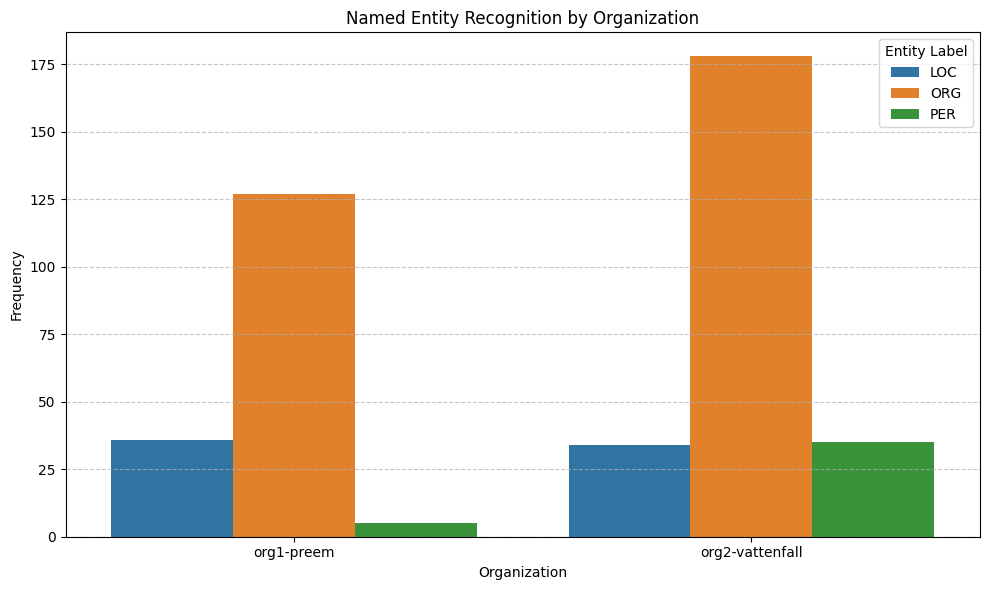

In [ ]:
import pandas as pd
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_sentences.tsv', sep='\t')

# Initialize the Hugging Face NER pipeline
ner_analyzer = pipeline("ner", model="Davlan/xlm-roberta-large-ner-hrl", aggregation_strategy="simple")

# Perform NER analysis and save results as a list of dicts
df['ner_results'] = df['sentence_text'].apply(lambda x: ner_analyzer(x))

# Flatten the NER results into a new DataFrame
ner_flattened = []
for index, row in df.iterrows():
    for entity in row['ner_results']:
        ner_flattened.append({
            'folder_name': row['folder_name'],
            'entity_label': entity['entity_group'],
            'confidence': entity['score']
        })

ner_df = pd.DataFrame(ner_flattened)

# Group and count entity labels by organization
entity_counts = ner_df.groupby(['folder_name', 'entity_label']).size().reset_index(name='frequency')

# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=entity_counts, x='folder_name', y='frequency', hue='entity_label')
plt.title("Named Entity Recognition by Organization")
plt.xlabel("Organization")
plt.ylabel("Frequency")
plt.legend(title="Entity Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Load Dataset**: The dataset is loaded from a tab-separated values file (`df_sentences.tsv`) into a Pandas DataFrame. This prepares the data for further analysis, including performing Named Entity Recognition (NER). Example: `df = pd.read_csv('df_sentences.tsv', sep='\t')`.

**Perform NER Analysis**: A Hugging Face NER pipeline is initialized using the multilingual transformer model `Davlan/xlm-roberta-large-ner-hrl` with `aggregation_strategy="simple"` to merge overlapping entities. The `ner_analyzer` is applied to the `sentence_text` column, saving the results (lists of dictionaries with entity labels and scores) in a new column, `ner_results`. Example: `df['ner_results'] = df['sentence_text'].apply(lambda x: ner_analyzer(x))`.

**Flatten NER Results**: The nested NER results are flattened into a new DataFrame, `ner_df`, where each row corresponds to an entity. The columns include the organization (`folder_name`), entity label (`entity_label`), and confidence score (`confidence`), enabling structured analysis of the detected entities. Example:
```python
for entity in row['ner_results']:
    ner_flattened.append({'folder_name': row['folder_name'], 'entity_label': entity['entity_group'], 'confidence': entity['score']})
```

**Group and Count Entities**: The NER results are grouped by organization (`folder_name`) and entity label (`entity_label`), and the frequency of each entity type is counted. This provides insights into how entities are distributed across organizations. Example: `entity_counts = ner_df.groupby(['folder_name', 'entity_label']).size().reset_index(name='frequency')`.

**Visualize Entity Distribution**: A grouped bar chart is created using Seaborn to display the frequency of each entity type for each organization. The x-axis represents organizations, the y-axis represents entity frequencies, and the legend differentiates entity labels. The chart is enhanced with titles, labels, and gridlines for clarity. Example:
```python
sns.barplot(data=entity_counts, x='folder_name', y='frequency', hue='entity_label')
plt.title("Named Entity Recognition by Organization")
```

# Transformers Sentiment Analysis

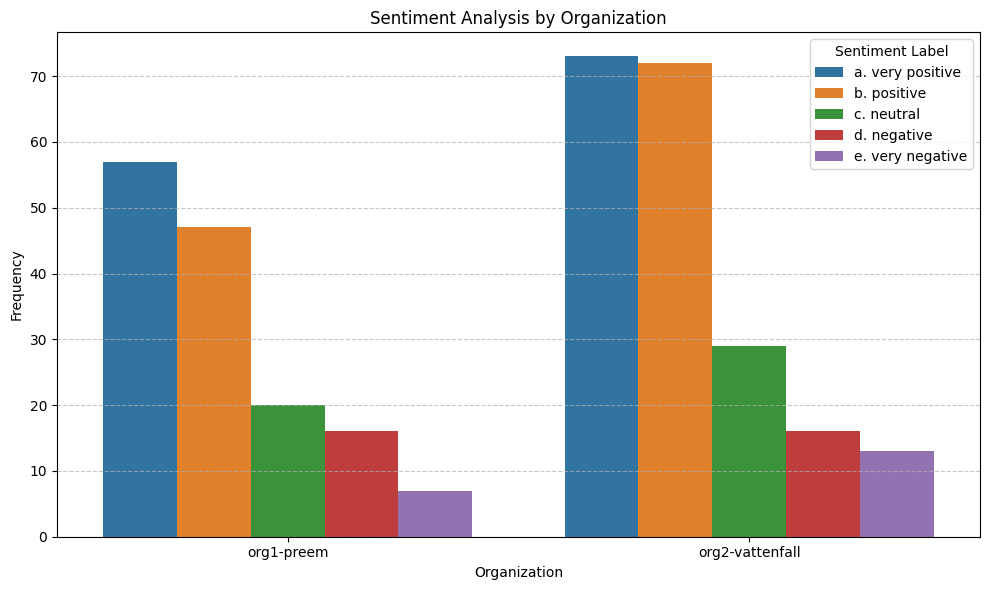

In [ ]:
import pandas as pd
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_sentences.tsv', sep='\t')

# Initialize the Hugging Face sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Perform sentiment analysis
results = df['sentence_text'].apply(lambda x: sentiment_analyzer(x)[0])

# Extract sentiment labels and confidence scores
df['sentiment_label_raw'] = results.apply(lambda x: x['label'])  # Original label (e.g., "1 star")
df['sentiment_score'] = results.apply(lambda x: x['score'])  # Confidence score

# Map sentiment labels to descriptive categories
sentiment_map = {
    "1 star": "e. very negative",
    "2 stars": "d. negative",
    "3 stars": "c. neutral",
    "4 stars": "b. positive",
    "5 stars": "a. very positive"
}
df['sentiment_label'] = df['sentiment_label_raw'].map(sentiment_map)

# Group and count sentiment labels by organization
sentiment_counts = df.groupby(['folder_name', 'sentiment_label']).size().reset_index(name='frequency')

# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_counts, x='folder_name', y='frequency', hue='sentiment_label')
plt.title("Sentiment Analysis by Organization")
plt.xlabel("Organization")
plt.ylabel("Frequency")
plt.legend(title="Sentiment Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Load Dataset**: The dataset is loaded from a tab-separated values file (`df_sentences.tsv`) into a Pandas DataFrame. This prepares the data for analysis, specifically for applying sentiment analysis to the `sentence_text` column. Example: `df = pd.read_csv('df_sentences.tsv', sep='\t')`.

**Perform Sentiment Analysis**: A Hugging Face sentiment analysis pipeline is initialized using the multilingual model `nlptown/bert-base-multilingual-uncased-sentiment`. The `sentiment_analyzer` is applied to the `sentence_text` column, and the first result (containing sentiment label and confidence score) is extracted for each sentence. Example: `results = df['sentence_text'].apply(lambda x: sentiment_analyzer(x)[0])`.

**Extract and Map Sentiment Labels**: The raw sentiment labels (e.g., "1 star") and confidence scores are extracted from the results and stored in the columns `sentiment_label_raw` and `sentiment_score`. The raw labels are then mapped to descriptive categories (e.g., "1 star" → "e. very negative") using a predefined dictionary. Example: `df['sentiment_label'] = df['sentiment_label_raw'].map(sentiment_map)`.

**Group and Count Sentiment Labels**: The sentiment data is grouped by `folder_name` (organization) and `sentiment_label` to calculate the frequency of each sentiment category for each organization. This aggregated data provides insights into sentiment distribution across organizations. Example: `sentiment_counts = df.groupby(['folder_name', 'sentiment_label']).size().reset_index(name='frequency')`.

**Visualize Sentiment Distribution**: A grouped bar chart is created using Seaborn to visualize the frequency of each sentiment category for each organization. The x-axis represents organizations, the y-axis represents sentiment frequency, and the legend differentiates sentiment categories. Titles, labels, and gridlines enhance readability. Example:
```python
sns.barplot(data=sentiment_counts, x='folder_name', y='frequency', hue='sentiment_label')
plt.title("Sentiment Analysis by Organization")
```

In [ ]:
# Extract the numeric value from sentiment_label_raw and store it in a new column
df['sentiment_numeric'] = df['sentiment_label_raw'].str.extract(r'(\d)').astype(int)

# Display the updated DataFrame with the new column
print(df[['sentiment_label_raw', 'sentiment_numeric']].head())


  sentiment_label_raw  sentiment_numeric
0             5 stars                  5
1             5 stars                  5
2             5 stars                  5
3             4 stars                  4
4             5 stars                  5


In [ ]:
# Sort the DataFrame by sentiment_numeric for each organization
most_positive = df.sort_values(by=['folder_name', 'sentiment_numeric'], ascending=[True, False])
most_negative = df.sort_values(by=['folder_name', 'sentiment_numeric'], ascending=[True, True])

# Extract the top 5 most positive texts for each organization
top_positive = most_positive.groupby('folder_name').head(5)[['folder_name', 'sentence_text', 'sentiment_label', 'sentiment_numeric']]

# Extract the top 5 most negative texts for each organization
top_negative = most_negative.groupby('folder_name').head(5)[['folder_name', 'sentence_text', 'sentiment_label', 'sentiment_numeric']]

# Display the results
print("Top 5 Most Positive Texts by Organization:")
print(top_positive)

print("\nTop 5 Most Negative Texts by Organization:")
print(top_negative)


Top 5 Most Positive Texts by Organization:
         folder_name                                      sentence_text  \
0         org1-preem  Carbon Capture and Storage | Preem https://www...   
1         org1-preem  Our commitment to carbon capture and storage P...   
2         org1-preem  This is why we are working actively to enable ...   
4         org1-preem  The "Preem CCS" pilot project has analyzed eve...   
8         org1-preem  FACTS: Carbon Capture and Storage (CCS) CCS st...   
147  org2-vattenfall  Vattenfall expands circular targes on wind tur...   
149  org2-vattenfall  Building on this commitment, the company is no...   
152  org2-vattenfall  Expanding our recycling target is a crucial st...   
153  org2-vattenfall  Our aim is to ensure that all decommissioned t...   
156  org2-vattenfall  Collaborations with various partners are alrea...   

      sentiment_label  sentiment_numeric  
0    a. very positive                  5  
1    a. very positive                  5  
2 

In [ ]:
df.head()

,text_index,folder_name,sentence_index,sentence_text,sentiment_label_raw,sentiment_score,sentiment_label
0,1,org1-preem,1,Carbon Capture and Storage | Preem https://www...,5 stars,0.323627,a. very positive
1,1,org1-preem,2,Our commitment to carbon capture and storage P...,5 stars,0.645176,a. very positive
2,1,org1-preem,3,This is why we are working actively to enable ...,5 stars,0.597687,a. very positive
3,1,org1-preem,4,"Tests have been conducted with good results, a...",4 stars,0.494041,b. positive
4,1,org1-preem,5,"The ""Preem CCS"" pilot project has analyzed eve...",5 stars,0.478207,a. very positive


In [ ]:
# Save the original DataFrame to a TSV file
df.to_csv('df_sentences_with_sentiment.tsv', sep='\t', index=False)
print("Original DataFrame saved to 'df_sentences_with_sentiment.tsv'")

Original DataFrame saved to 'df_sentences_with_sentiment.tsv'


# Transformers Text Summarization

In [ ]:
from transformers import pipeline

# Initialize the Hugging Face summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Generate a 4-paragraph sample text on NLP and text classification
text = """
Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and humans through natural language. It encompasses a wide range of applications, including machine translation, sentiment analysis, named entity recognition, and text classification. Over the years, NLP has become a vital component in building systems that can understand and respond to human language effectively.

Text classification is one of the most common tasks in NLP. It involves categorizing text into predefined classes, such as spam detection, topic labeling, or sentiment prediction. Machine learning algorithms like Naive Bayes, Support Vector Machines, and deep learning models such as transformers have been widely used for this purpose. These methods rely on feature extraction techniques like TF-IDF, word embeddings, or contextual embeddings to represent text for classification.

With the advent of transformers and pre-trained models like BERT, GPT, and RoBERTa, text classification has seen significant advancements. These models leverage attention mechanisms to capture context effectively, making them highly effective for understanding language semantics. They have set new benchmarks in various NLP tasks and enabled the development of applications like chatbots, recommendation systems, and content moderation tools.

Despite these advancements, challenges remain in NLP and text classification. Handling ambiguity, understanding figurative language, and addressing bias in training data are some of the pressing issues researchers and practitioners face today. Nonetheless, the continued evolution of NLP techniques holds promise for even more robust and inclusive language understanding systems in the future.
"""

# Apply summarization to the sample text
summary = summarizer(text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']

# Display the original text and its summary
print("Original Text:\n")
print(text)
print("\nSummary:\n")
print(summary)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Original Text:


Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and humans through natural language. It encompasses a wide range of applications, including machine translation, sentiment analysis, named entity recognition, and text classification. Over the years, NLP has become a vital component in building systems that can understand and respond to human language effectively.

Text classification is one of the most common tasks in NLP. It involves categorizing text into predefined classes, such as spam detection, topic labeling, or sentiment prediction. Machine learning algorithms like Naive Bayes, Support Vector Machines, and deep learning models such as transformers have been widely used for this purpose. These methods rely on feature extraction techniques like TF-IDF, word embeddings, or contextual embeddings to represent text for classification.

With the advent of transformers and pre-trained models like 